# Import all the packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Resizing, Rescaling

In [31]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

# Import data into tensorflow dataset object

In [32]:
dataset = image_dataset_from_directory(
    'Pepper',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [33]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [34]:
len(dataset)

78

In [35]:
for img_batch, lab_batch in dataset.take(1):
  print(img_batch.shape)
  print(lab_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


# Visualize some images from the dataset

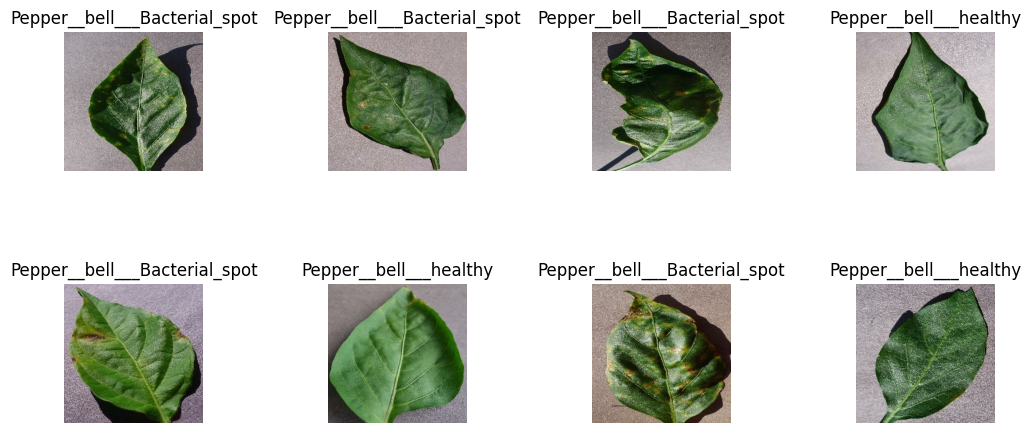

In [36]:
plt.figure(figsize=(12,6))
for img_batch, lab_batch in dataset.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(img_batch[i].numpy().astype('uint8'))
    plt.title(class_names[lab_batch[i]])
    plt.axis('off')
    plt.subplots_adjust(wspace=0.9, hspace=0.2)

# Split the dataset

In [37]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [39]:
len(train_ds)

62

In [40]:
len(val_ds)

7

In [41]:
len(test_ds)

9

# Cache, Shuffle, and Prefetch the Dataset

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Preprocessing and Data Augmentation

In [43]:
resize_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255),])

In [44]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),])

In [45]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Build the Model

In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model

In [49]:
history = model.fit(
    train_ds, 
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,)

Epoch 1/10
62/62 [==============================] - 34s 528ms/step - loss: 0.6358 - accuracy: 0.6322 - val_loss: 0.4746 - val_accuracy: 0.8259
Epoch 2/10
62/62 [==============================] - 32s 521ms/step - loss: 0.3850 - accuracy: 0.8411 - val_loss: 0.5367 - val_accuracy: 0.8616
Epoch 3/10
62/62 [==============================] - 33s 527ms/step - loss: 0.1813 - accuracy: 0.9511 - val_loss: 0.3385 - val_accuracy: 0.9554
Epoch 4/10
62/62 [==============================] - 33s 535ms/step - loss: 0.1988 - accuracy: 0.9470 - val_loss: 0.3251 - val_accuracy: 0.9420
Epoch 5/10
62/62 [==============================] - 34s 545ms/step - loss: 0.0973 - accuracy: 0.9776 - val_loss: 0.1134 - val_accuracy: 0.9911
Epoch 6/10
62/62 [==============================] - 34s 540ms/step - loss: 0.0631 - accuracy: 0.9878 - val_loss: 0.0887 - val_accuracy: 0.9955
Epoch 7/10
62/62 [==============================] - 39s 629ms/step - loss: 0.0532 - accuracy: 0.9918 - val_loss: 0.0441 - val_accuracy: 0.9955

In [50]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 2s 146ms/step - loss: 0.0093 - accuracy: 0.9965


In [51]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 62}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

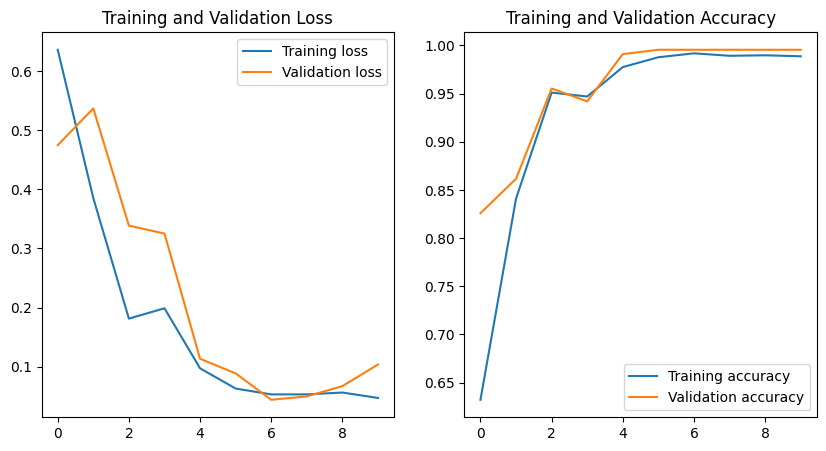

In [54]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Training and Validation Loss')
plt.plot(range(EPOCHS), train_loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('Training and Validation Accuracy')
plt.plot(range(EPOCHS), train_acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right');

# Predictions on sample images

Frist image to predict
Actual label: Pepper__bell___healthy
1/1 [==============================] - 0s 213ms/step
Predicted label: Pepper__bell___Bacterial_spot


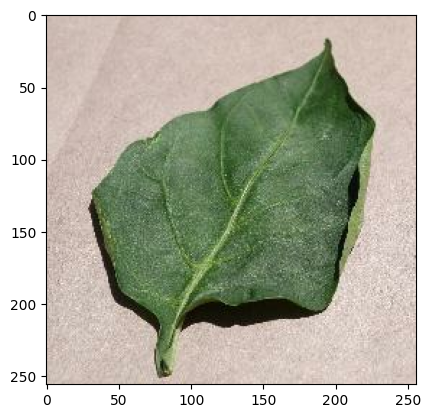

In [56]:
for img_batch, lab_batch in test_ds.take(1):
    first_im = img_batch[0].numpy().astype('uint8')
    first_lab = lab_batch[0].numpy()
    
    print('Frist image to predict')
    plt.imshow(first_im)

    print('Actual label:', class_names[first_lab])

    batch_pred_prob = model.predict(img_batch)

    threshold = 0.5
    batch_pred = (batch_pred_prob > threshold).astype(int)
    print('Predicted label:', class_names[predicted_labels[0][0]])

In [74]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, axis=0)

    pred_prob = model.predict(img_arr)
    threshold = 0.5
    
    pred = (pred_prob > threshold).astype(int)
    pred_class = class_names[pred[0][0]]
    
    return pred_class

1/1 [==============================] - 0s 12ms/step


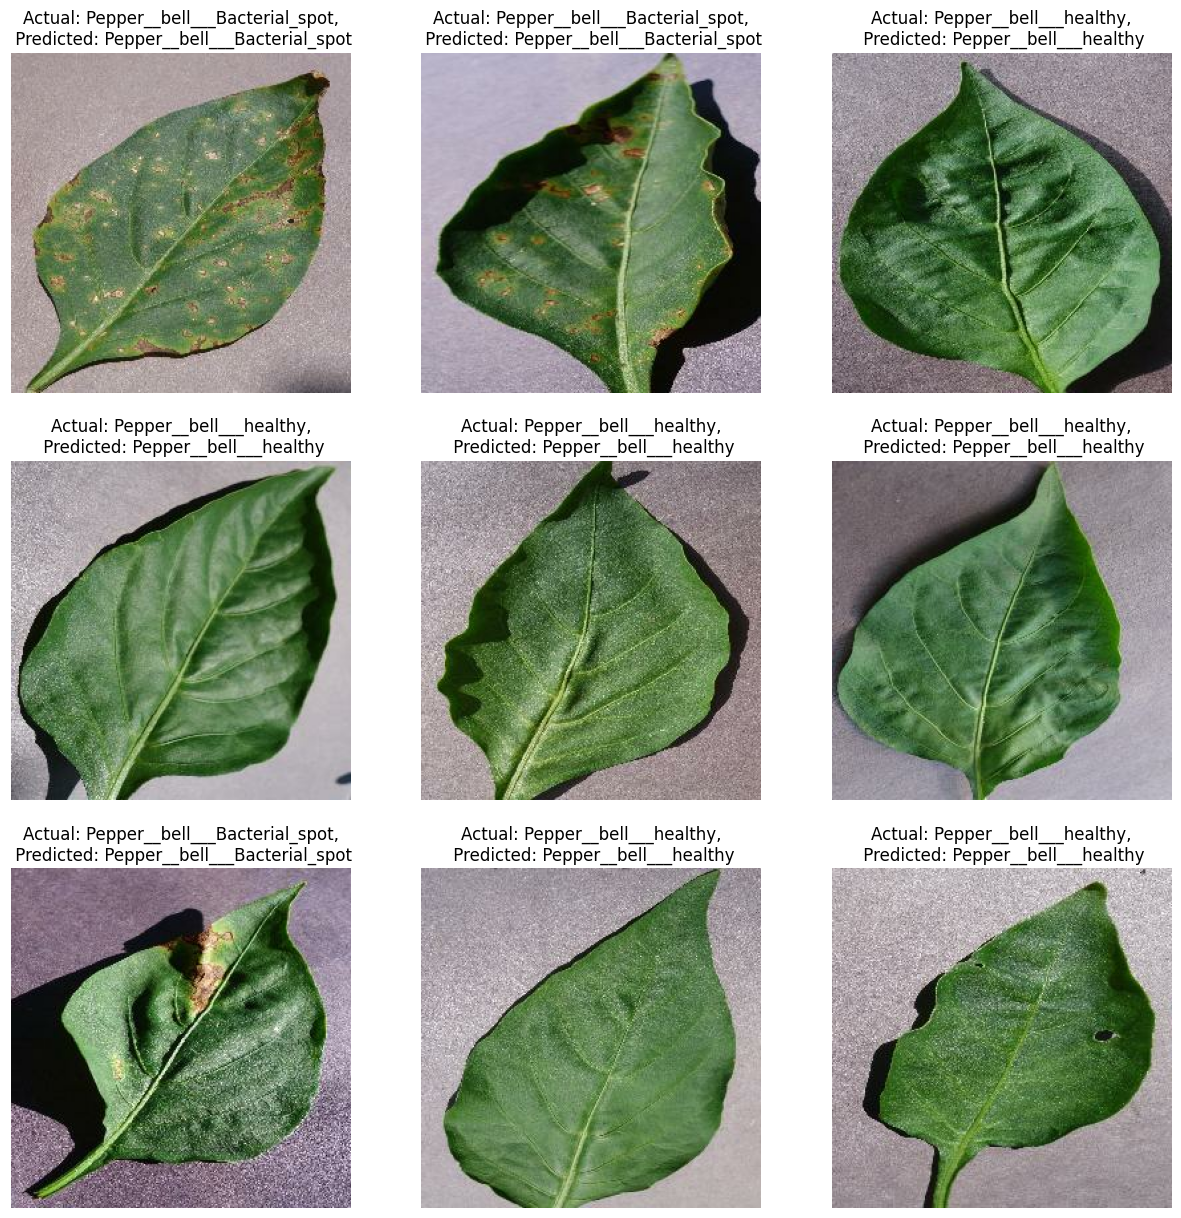

In [76]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = predict(model, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
        
        plt.axis("off")